In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
from scipy import stats
import seaborn as sns
style.use('ggplot')
%matplotlib inline

In [2]:
#Helper function

def winner(row, home_col, away_col):
    """helper function returns if the home team or away team won """
    if row[home_col]>row[away_col]:
        return "home"
    elif row[home_col]<row[away_col]:
        return "away"
    else:
        return "tie"

def is_home_field_advantage(x, col):
    """helper function returns True if the country in 'col' is the host country"""
    if x['Country'] == 'Korea/Japan':
        return ('Korea' in x[col]) or ('Japan' in x[col])
    else:
        return x['Country'] in x[col]

def host_place(x):
    """helper function returns the finishing place of the host country (1-4)"""
    if x['Country']=='Korea/Japan':
        c = 'Korea'
    else:
        c = x['Country']
    if c in x['Winner']:
        return 1
    elif c in x['Runners-Up']:
        return 2
    elif c in x['Third']:
        return 3
    elif c in x['Fourth']:
        return 4

def host_team_result(x):
    """helper function to determine if the host team won a match"""
    if x['home_field_advantage_away']:
        if x['Winner']=='home':
            return 'loss'
        elif x['Winner']=='tie':
            return 'tie'
        else:
            return "win"
    elif x['home_field_advantage_home']:
        if x['Winner']=='home':
            return 'win'
        elif x['Winner']=='tie':
            return 'tie'
        else:
            return "loss"

In [3]:
#PREPROCESSING:
#read in data
wcm = pd.read_csv('data/WorldCupMatches.csv')
wcp = pd.read_csv('data/WorldCupPlayers.csv')
wc = pd.read_csv('data/WorldCups.csv')

#cleanup
wc['Attendance'] = wc['Attendance'].apply(lambda x: int(x.replace('.', '')))
wcm.dropna(subset = ['Year'], inplace = True)
wcp = wcp.drop_duplicates()

#Add some columns
wc['host_place'] = wc.apply(host_place, axis =1)
wcm['2nd Half Home Goals'] = wcm['Home Team Goals'] - wcm['Half-time Home Goals']
wcm['2nd Half Away Goals'] = wcm['Away Team Goals'] - wcm['Half-time Away Goals']
wcm['half time diff'] = wcm['Half-time Away Goals']- wcm['Half-time Home Goals']
wcm['2nd half diff'] = wcm['2nd Half Away Goals']- wcm['2nd Half Home Goals']
wcm['overall diff'] =  wcm['Away Team Goals'] - wcm['Home Team Goals'] 

#merge Year and Host Country to wcm
wcm = wcm.merge(wc[['Year', 'Country']], on = 'Year')

#Add more columns
wcm['Winner'] = wcm.apply(lambda x: winner(x, 'Home Team Goals', 'Away Team Goals'), axis = 1)
wcm['1H Winner'] = wcm.apply(lambda x: winner(x, 'Half-time Home Goals', 'Half-time Away Goals'), axis = 1)
wcm['2H Winner'] = wcm.apply(lambda x: winner(x, '2nd Half Home Goals', '2nd Half Away Goals'), axis = 1)
wcm['home_field_advantage_home'] = wcm.apply(lambda x:  is_home_field_advantage(x, 'Home Team Name'), axis = 1)
wcm['home_field_advantage_away'] = wcm.apply(lambda x:is_home_field_advantage(x, 'Away Team Name'), axis = 1)
a = wcm.groupby(['Year', 'Stage'])['MatchID'].count().reset_index()
a.rename(columns = {'MatchID': "num_games_in_stage"}, inplace = True)
wcm = wcm.merge(a, on = ['Year', 'Stage'])


# 1. World Cup Summary Data

From the world cup summary table ("WorldCups" aka wc), we can see evidence that the game has changed over the years. 
While totals like # goals scored and attendance have an upward trend, when normalized by logistical metrics like # of matches and teams, we can compare between years better.

Normalizing goals scored by number of matches shows that while total goals have increased since 1930, goals per match have decreased by nearly 2 goals. It would be interesting to investigate if there were changes to the rules corresponding to the years with the steepest declines in goals per match.

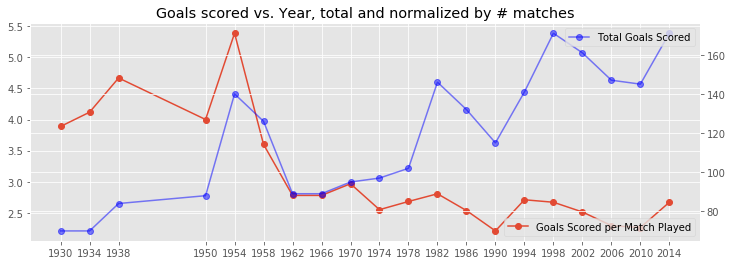

In [4]:
fig, ax = plt.subplots(figsize = (12,4))
ax1 = ax.twinx()
ax.plot(wc['Year'], wc['GoalsScored']/wc['MatchesPlayed'], '-o', label = "Goals Scored per Match Played")
ax.set_title('Goals scored vs. Year, total and normalized by # matches')
ax1.plot(wc['Year'], wc['GoalsScored'],'-o', alpha = 0.5, color = 'blue', label = 'Total Goals Scored')
ax.set_xticks(wc['Year'])
ax1.legend(loc = 1)
ax.legend(loc = 4)

Attendance per year is overall up, with a spike in 1994 when the USA hosted the world cup. We might expect attendance to increase somewhat proportionally with # qualified teams since that team would have it's own fans.
However, with the exception of the 1994 world cup, attendance per qualified team has hovered around 100,000 fans per qualified team. Attendance may be more related to other factors, like location, then what teams have qualified.

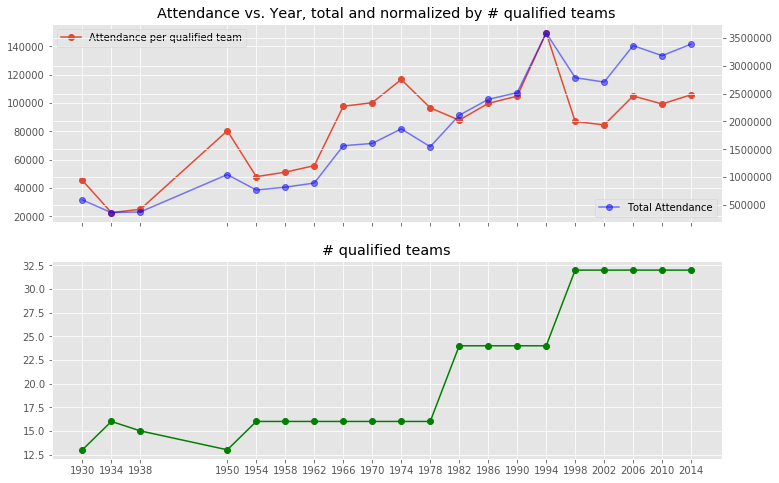

In [5]:
fig, (axa, axb) = plt.subplots(2,figsize = (12,8), sharex = True)
ax1 = axa.twinx()
axa.plot(wc['Year'], wc['Attendance']/wc['QualifiedTeams'], '-o', label = 'Attendance per qualified team')
axa.set_title('Attendance vs. Year, total and normalized by # qualified teams')
ax1.plot(wc['Year'], wc['Attendance'], '-o',alpha = 0.5, color = 'blue', label = 'Total Attendance')
axa.set_xticks(wc['Year'])
ax1.legend(loc = 4)
axa.legend(loc = 2)
axb.set_title('# qualified teams')
axb.plot(wc['Year'], wc['QualifiedTeams'], '-o', color = 'green')

Digging a little deeper into the location data, we can look at the frequency in which the host country placed in the World Cup. In 6/20 World Cups, the host team won, and in 13/20 the host country reached the semifinals. 

Text(0.5,1,u'Frequency of host team finish place')

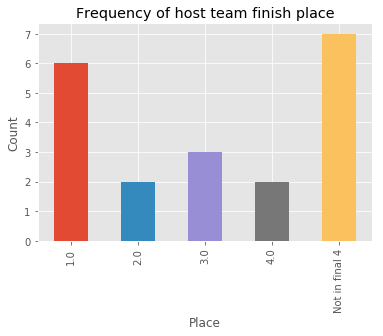

In [6]:
fig, ax = plt.subplots()
wc['host_place'].fillna('Not in final 4').value_counts().sort_index().plot(kind= 'Bar', ax = ax)
ax.set_xlabel("Place")
ax.set_ylabel('Count')
ax.set_title('Frequency of host team finish place')

Without knowing the team's rankings coming in, it's difficult to say how improbable this is. Plotting host team place vs. year, we can see that the host team has not won since 1998. This may be due to increased difficulty from the increase in qualified teams. 

Still, it seems there may be some home field advantage that we can explore in more detail by looking at the other data sets.

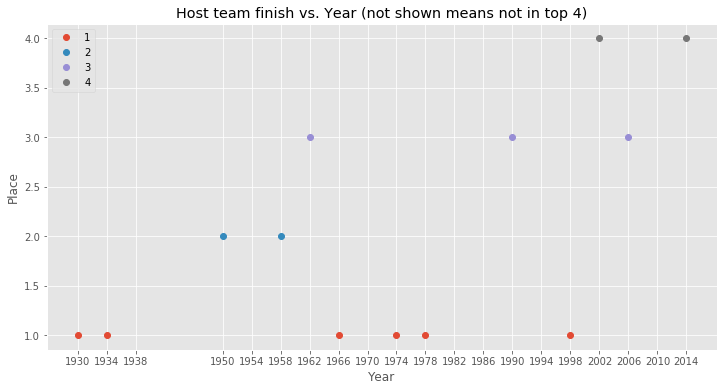

In [7]:
fig, ax = plt.subplots(figsize = (12,6) )
ax.plot(wc[wc['host_place']==1]['Year'], wc[wc['host_place']==1]['host_place'], 'o', label = 1)
ax.plot(wc[wc['host_place']==2]['Year'], wc[wc['host_place']==2]['host_place'], 'o', label = 2)
ax.plot(wc[wc['host_place']==3]['Year'], wc[wc['host_place']==3]['host_place'], 'o', label = 3)
ax.plot(wc[wc['host_place']==4]['Year'], wc[wc['host_place']==4]['host_place'], 'o', label = 4)
ax.set_xlabel("Year")
ax.set_ylabel('Place')
ax.set_title('Host team finish vs. Year (not shown means not in top 4)')
ax.set_xticks(wc['Year'])
ax.legend()

# 2. World Cup Match Data

Keeping in mind the evidence of home field advantage from part 1, let's look into scoring.

In each match, teams are labeled as "home" or "away" even though often neither are actually in their home country. From the dataset creator, "home" or "away" is defined by FIFA through a draw (a quick google search turns up that the draws can be quite complicated). Looking at the data, there are unexpected trends related to "home" and "away" that the draw is not random and the home team is typically much better than the away team. 

For example, the team labeled "away" only won 1 match until 1974. Overall, only 20% of wins are from the "away" team. Without knowing the details of the draw, it seems being the "away" team is a disadvantage. 

Text(0.5,1,u'Winner Count (home, away or tie) vs. Year')

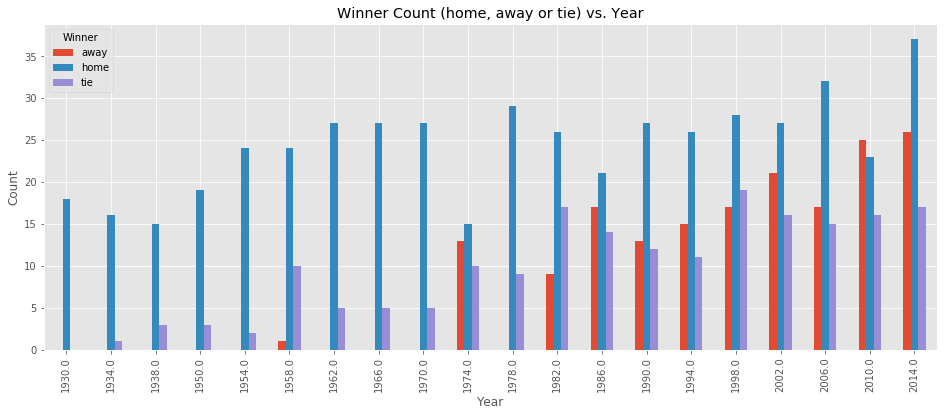

In [8]:
winner_df = wcm.groupby(['Year', 'Winner']).count()['MatchID'].reset_index().pivot(index = 'Year', columns = 'Winner', values = 'MatchID')

fig, ax = plt.subplots(figsize = (16, 6))
winner_df.plot(kind = 'bar', ax = ax)
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_title('Winner Count (home, away or tie) vs. Year')

Looking further into points scored, the home team averages one more goal per game than the away team. The difference in means is significant (p < 0.05)

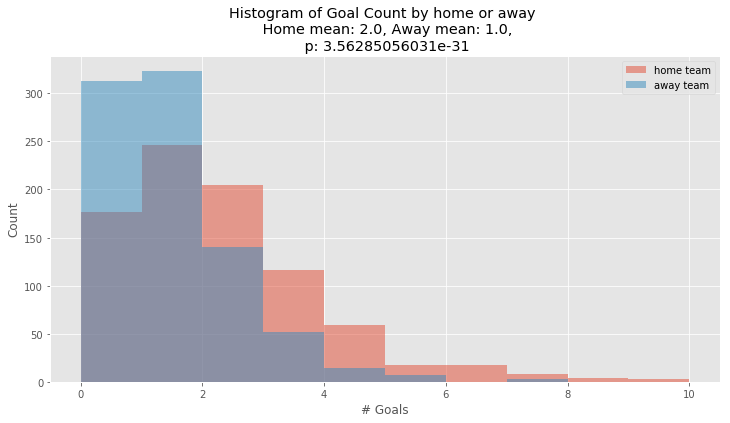

In [9]:
t, p_value = stats.ttest_ind(wcm['Home Team Goals'],wcm['Away Team Goals'])
h_mean = np.round(wcm['Home Team Goals'].mean())
a_mean = np.round(wcm['Away Team Goals'].mean())

fig, ax = plt.subplots(figsize = (12,6))
n, b, p = ax.hist(wcm['Home Team Goals'], alpha = 0.5, label = "home team")
ax.hist(wcm['Away Team Goals'], bins = b, alpha = 0.5, label = "away team")
ax.set_xlabel('# Goals')
ax.set_ylabel('Count')
ax.set_title('Histogram of Goal Count by home or away \n Home mean: {}, Away mean: {},\n p: {}'.format(h_mean, a_mean, p_value))
ax.legend()

We can also look at the match result given the winner at halftime. 

For all games in which the away team is winning at halftime, what percentage of those games result in the away team winning overall? the home team? a tie?

What about games in which the home team is winning at halftime or in which halftime is tied? What percentage of them end up in each category?

[Text(0.5,0,u'away'), Text(1.5,0,u'home'), Text(2.5,0,u'tie')]

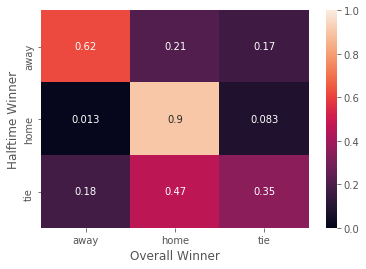

In [10]:
win_cm = wcm.groupby(['1H Winner', 'Winner']).count()['MatchID'].reset_index().pivot(index = '1H Winner', columns = 'Winner')
win_cm_pct = win_cm.div(win_cm.sum(axis=1), axis=0)
fig, ax = plt.subplots()
sns.heatmap(win_cm_pct, annot=True, vmin = 0, vmax = 1, ax = ax)
ax.set_xlabel('Overall Winner')
ax.set_ylabel('Halftime Winner')
ax.set_xticklabels(['away', 'home', 'tie'])

* 90% of games in which the home team is up at halftime end in a home team victory 
* Only 62% of games in which the away team is up at halftime end in an away team victory.
* For games tied at half, 47% of them end up with a home team win while only 18% of them end in a half time win.

While initially we were asking about the home country having a home field advantage, the advantage for the team labeled "home" is an intersting area to explore. The answers to the patterns may lie in the details of the draws or other intracacies of world cup rules. We can return to the question of looking at the performance of host countries on their home fields.  


In [11]:
host_df  = wcm[wcm['home_field_advantage_home'] | wcm['home_field_advantage_away'] ].copy()
host_df['host_result'] = host_df.apply(lambda x: host_team_result(x), axis = 1)

Host countries only lose 20% of matches. 

Text(0.5,1,u'Host Country Result')

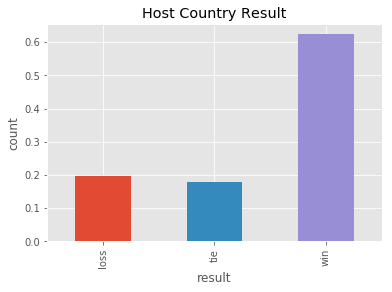

In [12]:
(host_df.groupby('host_result').count()['MatchID']/host_df.groupby('host_result').count()['MatchID'].sum()).plot(kind = 'bar')
plt.xlabel('result')
plt.ylabel('count')
plt.title('Host Country Result')

With more time I would look at...
* Defending champion performance between world cups
* Process the "stage" column in the match table so it can be compared between years. Analyze scoring at each stage.
* Performance of teams that qualify for the first time vs. legacy teams
* The meaning of the event column in the player table
* Analysis of teams with multiple scorers vs. teams with one "star" player